## QUESTO FILE VA CAMBIATO PERCHE' L'ID NON CORRISPONDE PIU' AL TEMPO!!!

In [290]:
import ast
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from utils_martina.my_utils import *

In [291]:
# Set patient and record
patient_id = "chb04"
record_id = "28"

In [292]:
with open(f"EEG_data\EEG_data_params_{patient_id}_{record_id}.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

indici = loaded_variables["indici"]
Start = loaded_variables["Start"]
End = loaded_variables["End"]
seizure_starts = loaded_variables["seizure_starts"]
seizure_ends = loaded_variables["seizure_ends"]
seizure_class = loaded_variables["seizure_class"]

In [293]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"

In [294]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

17900-Martina


In [295]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

## Oracle and explainer metrics

In [296]:
# Creazione di un dizionario per ciascuna metrica
RuntimeMetric = estrai_dizionario_da_runtime_metric(content,"RuntimeMetric")
GraphEditDistanceMetric = estrai_dizionario_da_runtime_metric(content,"GraphEditDistanceMetric")
OracleCallsMetric = estrai_dizionario_da_runtime_metric(content,"OracleCallsMetric")
CorrectnessMetric = estrai_dizionario_da_runtime_metric(content,"CorrectnessMetric")
SparsityMetric = estrai_dizionario_da_runtime_metric(content,"SparsityMetric")
FidelityMetric = estrai_dizionario_da_runtime_metric(content,"FidelityMetric")
OracleAccuracyMetric = estrai_dizionario_da_runtime_metric(content,"OracleAccuracyMetric")
EmbeddingMetric = estrai_dizionario_da_runtime_metric(content,"EmbeddingMetric")

# Estrazione di tempi e record
dict_time, dict_record = estrai_time_e_record(content)

In [297]:
RuntimeMetric = {id: value for id, value in RuntimeMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
GraphEditDistanceMetric = {id: value for id, value in GraphEditDistanceMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleCallsMetric = {id: value for id, value in OracleCallsMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
CorrectnessMetric = {id: value for id, value in CorrectnessMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
SparsityMetric = {id: value for id, value in SparsityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
FidelityMetric = {id: value for id, value in FidelityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleAccuracyMetric = {id: value for id, value in OracleAccuracyMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
EmbeddingMetric = {id: value for id, value in EmbeddingMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}

In [298]:
# Calcolo degli istanti temporali associati ai grafi
id_grafi = [id for id, value in dict_record.items() if value == f"{patient_id}_{record_id}"]
tempi_grafi = [dict_time[id] for id in id_grafi]

indici_test = []
tempi_test = []

for id in tempi_grafi:
    indici_test.append(indici[id])
    tempi_test.append(indici[id]/256 + Start)

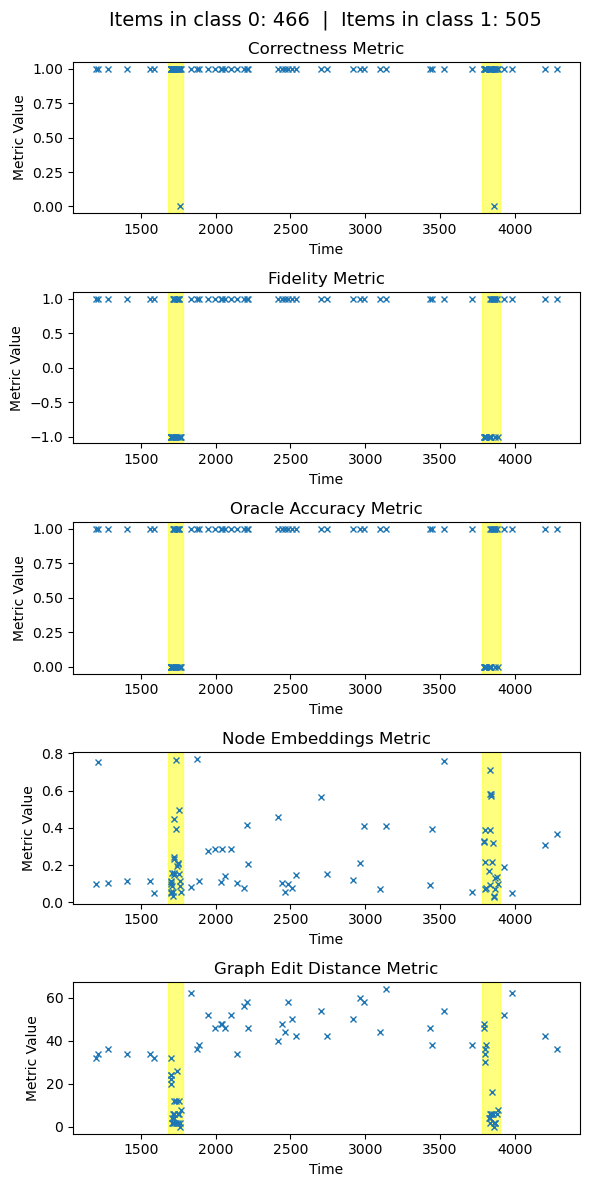

In [299]:
# Funzione per aggiungere le aree di crisi (seizure)
def add_seizure_shading(ax, starts, ends, also_horizontal=False):
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='yellow', alpha=0.5)

        if also_horizontal:
            ax.axhspan(start, end, color='orange', alpha=0.5)

# Crea la figura e i subplots
fig, axes = plt.subplots(5, 1, figsize=(6,12))

# Subplot 1: CorrectnessMetric
add_seizure_shading(axes[0], seizure_starts, seizure_ends)
axes[0].plot(tempi_test, np.array(list(CorrectnessMetric.values())), marker='x', linestyle='', markersize=5, label='Correctness')
axes[0].set_title('Correctness Metric')

# Subplot 2: FidelityMetric
add_seizure_shading(axes[1], seizure_starts, seizure_ends)
axes[1].plot(tempi_test, np.array(list(FidelityMetric.values())), marker='x', linestyle='', markersize=5, label='Fidelity')
axes[1].set_title('Fidelity Metric')

# Subplot 3: OracleAccuracyMetric
add_seizure_shading(axes[2], seizure_starts, seizure_ends)
axes[2].plot(tempi_test, np.array(list(OracleAccuracyMetric.values())), marker='x', linestyle='', markersize=5, label='Oracle Accuracy')
axes[2].set_title('Oracle Accuracy Metric')

# Subplot 4: EmbeddingsMetric
add_seizure_shading(axes[3], seizure_starts, seizure_ends)
axes[3].plot(tempi_test, np.array(list(EmbeddingMetric.values())), marker='x', linestyle='', markersize=5, label='Node Embeddings Metric')
axes[3].set_title('Node Embeddings Metric')

# Subplot 5: GraphEditDistanceMetric
add_seizure_shading(axes[4], seizure_starts, seizure_ends)
axes[4].plot(tempi_test, np.array(list(GraphEditDistanceMetric.values())), marker='x', linestyle='', markersize=5, label='Graph Edit Distance Metric')
axes[4].set_title('Graph Edit Distance Metric')

# Aggiunge etichetta comune per l'asse x
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Metric Value')
    # ax.set_xlim((Start,End))

text = f"Items in class 0: {seizure_class.count(0)}  |  Items in class 1: {seizure_class.count(1)}"
fig.suptitle(text, fontsize=14, x=0.55, y=0.985)
plt.tight_layout()
plt.show()

## Density

In [300]:
import re
import ast

def get_other_info(content, search):
    # Funzione che estrae e converte il JSON dalle righe del contenuto
    for line in content.splitlines():
        if search in line:
            match = re.search(r'(\[.*\])', line)
            if match:
                json_str = match.group(1)
                json_data = ast.literal_eval(json_str)
                return json_data

# graph_ids = get_other_info(content, 'graph_ids') # NON È STATO SISTEMATO PER CONTEMPLARE IL CASO DI PIU' PAZIENTI
graph_metrics = get_other_info(content, 'graph_metrics')

# graph_ids = [entry for entry in graph_ids if dict_record[str(entry['instance_id'])] == f"{patient_id}_{record_id}"] # NON È STATO SISTEMATO PER CONTEMPLARE IL CASO DI PIU' PAZIENTI
graph_metrics = [entry for entry in graph_metrics if dict_record[str(entry['instance_id'])] == f"{patient_id}_{record_id}"]

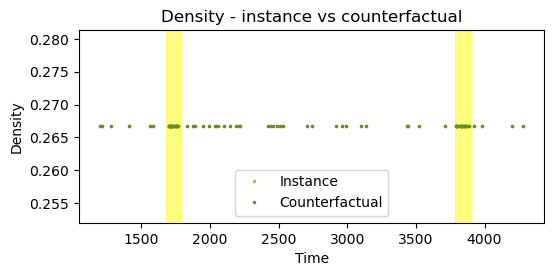

In [301]:
fig, ax = plt.subplots(figsize=(6,2.5))

# Subplot 1: Density
add_seizure_shading(ax, seizure_starts, seizure_ends)
ax.plot(tempi_test, np.array([entry['density_instance'] for entry in graph_metrics]), marker='.', color='yellowgreen', linestyle='', markersize=3, label='Instance')
ax.plot(tempi_test, np.array([entry['density_counterfactual'] for entry in graph_metrics]), marker='.', color='olivedrab', linestyle='', markersize=3, label='Counterfactual')
ax.set_title('Density - instance vs counterfactual')
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.legend()
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Number of edges

In [302]:
def get_number_edges(evaluator):
    result = []

    for g1, g2 in evaluator.get_instance_explanation_pairs():
        # Crea grafi da matrici di adiacenza
        G_orig = nx.from_numpy_array(g1.data)

        # Differenza tra le matrici di adiacenza
        A_differenza = g1.data - g2.data
        archi_aggiunti = nx.from_numpy_array(A_differenza == -1)
        archi_rimossi = nx.from_numpy_array(A_differenza == 1)

        result.append({ 'id': g1.id, 'patient_record': f"{g1.patient_id}_{g1.record_id}", 'original': G_orig.number_of_edges(), 'added': archi_aggiunti.number_of_edges(), 'removed': archi_rimossi.number_of_edges() })
    
    return result

85
85


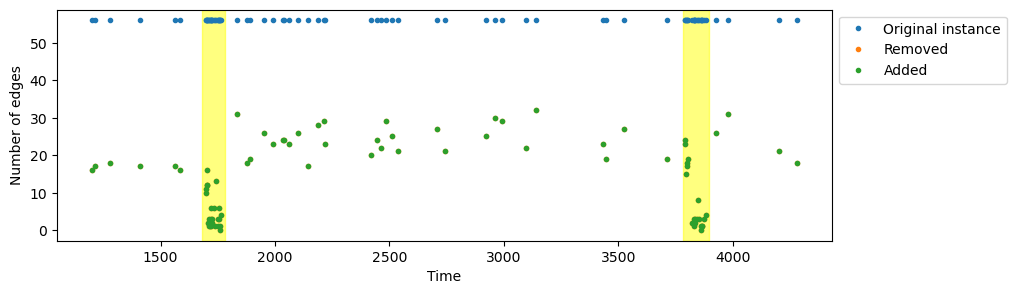

In [303]:
def plot_number_edges(evaluator, tempi_test):
    a = get_number_edges(evaluator)
    a = [entry for entry in a if entry['patient_record'] == f"{patient_id}_{record_id}"]

    original = [entry['original'] for entry in a]
    added = [entry['added'] for entry in a]
    removed = [entry['removed'] for entry in a]

    print(len(tempi_test))
    print(len(original))

    fig, ax = plt.subplots(1,figsize=(10,3))
    ax.plot(tempi_test, original, label='Original instance', marker='.', linestyle='')
    ax.plot(tempi_test, removed, label='Removed', marker='.', linestyle='')
    ax.plot(tempi_test, added, label='Added', marker='.', linestyle='')

    add_seizure_shading(ax, seizure_starts, seizure_ends)

    ax.set_xlabel('Time')
    ax.set_ylabel('Number of edges')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

plot_number_edges(eval_manager._evaluators[0], tempi_test)

## Instance vs counterfactual

In [304]:
# NON È STATO SISTEMATO PER CONTEMPLARE IL CASO DI PIU' PAZIENTI

# # Calcolo degli istanti temporali associati ai grafi
# id_instance = [entry['instance_id'] for entry in graph_ids]
# id_counterfactual = [entry['counterfactual_id'] for entry in graph_ids]

# t_instance = []
# t_counterfactual = []

# for id in id_instance:
#     t_instance.append(indici[id]/256 + Start)

# for id in id_counterfactual:
#     t_counterfactual.append(indici[id]/256 + Start)

# # Figura
# fig, ax = plt.subplots(figsize=(5,5))
# add_seizure_shading(ax, seizure_starts, seizure_ends, also_horizontal=True)
# ax.scatter(np.array(t_instance), np.array(t_counterfactual), marker='.', color='darkgoldenrod', s=5)
# ax.set_title('Graph ids - instance vs counterfactual')
# ax.set_xlim([Start-50,End+50])
# ax.set_ylim([Start-50,End+50])
# ax.set_xlabel('Instance')
# ax.set_ylabel('Counterfactual')

# # indici_zero = [i for i, value in enumerate(OracleAccuracyMetric.values()) if value == 0]

# # for index in indici_zero:
# #     # Traccia una linea verticale
# #     ax.axvline(x=tempi_test[index], color='red', linestyle=':', linewidth=1, alpha=0.3)
# #     # Traccia una linea orizzontale
# #     ax.axhline(y=tempi_test[index], color='red', linestyle=':', linewidth=1, alpha=0.3)

# plt.show()

## _______________________________________________________________

In [305]:
import datetime

now = datetime.datetime.now()
print("Ultima esecuzione completa:", now.strftime("%d/%m/%Y, ore %H:%M"))

Ultima esecuzione completa: 06/03/2025, ore 14:54
